# Enefit - Predict Energy Behavior of Prosumers | Data Viz

<img src="./header.png" width="1200" height="400"/>

## 1. Import ncessary libraries 

In [13]:
import numpy as np
import pandas as pd
import os
import warnings
from plotly.subplots import make_subplots
import plotly.offline as offline
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor

pool_executor = ThreadPoolExecutor()

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15

COLORS = list(sns.color_palette("husl", 8))

offline.init_notebook_mode(connected = True)
warnings.filterwarnings('ignore')

In [21]:
INPUT_DIR = '../../../Kaggle_input/input/Enefit-Predict-Energy-Behavior/predict-energy-behavior-of-prosumers/'

In [22]:
os.listdir(INPUT_DIR)

['county_id_to_name_map.json',
 'client.csv',
 'example_test_files',
 'train_merged.pkl',
 'enefit',
 'weather_station_to_county_mapping.csv',
 'train.csv',
 'public_timeseries_testing_util.py',
 'gas_prices.csv',
 'historical_weather.csv',
 'forecast_weather.csv',
 'electricity_prices.csv']

In [23]:
train = pd.read_pickle(f"{INPUT_DIR}/train_merged.pkl")

In [6]:
train.head()

,county,is_business,product_type,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,...,surface_pressure,cloudcover_total_hw,cloudcover_low_hw,cloudcover_mid_hw,cloudcover_high_hw,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation_hw,diffuse_radiation
0,0,0,1,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,...,1008.433333,58.833333,61.500000,4.166667,3.833333,4.972222,340.000000,0.0,0.0,0.0
1,0,0,1,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,...,1008.433333,58.833333,61.500000,4.166667,3.833333,4.972222,340.000000,0.0,0.0,0.0
2,0,0,1,0,2021-09-01 01:00:00,0,122,0,2021-09-01,01:00:00,...,1008.350000,32.333333,29.666667,1.166667,15.833333,5.069444,344.833333,0.0,0.0,0.0
3,0,0,1,1,2021-09-01 01:00:00,0,123,0,2021-09-01,01:00:00,...,1008.350000,32.333333,29.666667,1.166667,15.833333,5.069444,344.833333,0.0,0.0,0.0
4,0,0,1,0,2021-09-01 02:00:00,0,244,0,2021-09-01,02:00:00,...,1008.000000,16.500000,17.166667,0.166667,3.000000,4.907407,340.666667,0.0,0.0,0.0


## 2. Exploring the Data

### 2.1 Data Summary

In [19]:
num_county = train.county.nunique()
num_product_type = train.product_type.nunique()
num_pred_unit = train.prediction_unit_id.nunique()
num_prod = train[train.is_consumption.eq(0)].is_consumption.count()
num_con = train[train.is_consumption.eq(1)].is_consumption.count()
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_range_len = (train_end - train_start).days + 1

formatted_values = [f"<span style='font-size:25px'><b>{num_county}</b></span>",
                   f"<span style='font-size:25px'><b>{num_product_type}</b></span>",
                   f"<span style='font-size:25px'><b>{num_pred_unit}</b></span>",
                   f"<span style='font-size:25px'><b>{num_prod}</b></span>",
                   f"<span style='font-size:25px'><b>{num_con}</b></span>",
                   f"<span style='font-size:25px'><b>{num_train_date}</b></span>",
                   f"<span style='font-size:25px'><b>{train_range_len}</b></span>",]
headings = ["Counties", "Product Types", "Prediction Units", "# Consumption", "# Production", "# Train Dates", "# Train Date Range"]

fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3, 4, 5, 6, 7],
    y=[1.6] * 7,
    mode="text", 
    text=formatted_values,
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3, 4, 5, 6, 7],
    y=[1.1] * 7,
    mode="text", 
    text=headings,
    textposition="bottom center"
))
fig.add_hline(y=2.2, line_width=5, line_color='gray')
fig.add_hline(y=0.0, line_width=3, line_color='gray')
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=1300, 
                  title='Data Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.4,7], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=20, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=10,b=0,r=80), 
    )

In [24]:
train.drop(columns=["time", "data_block_id_fw"], inplace=True)

In [25]:
train.shape

(2018352, 43)

### 2.2 Target Distribution

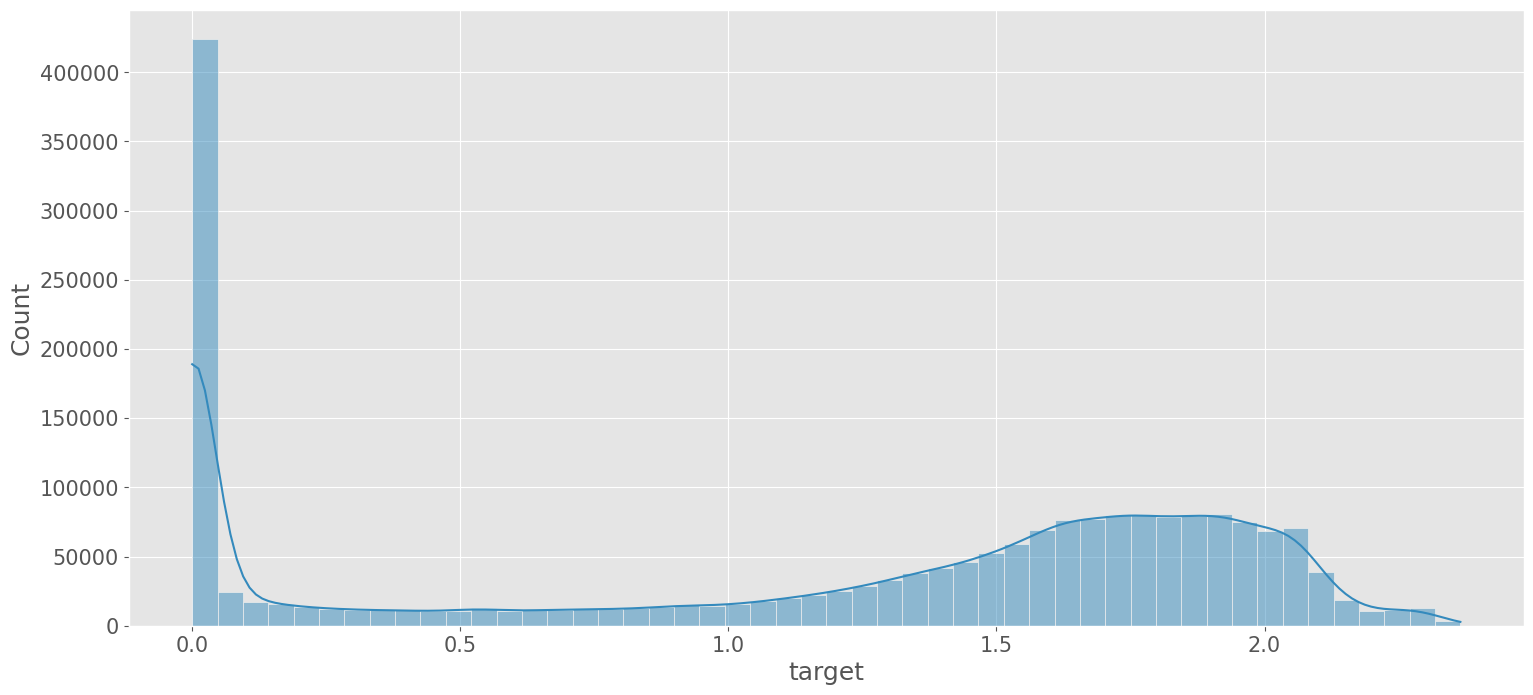

In [140]:
# Plot distribution of target variable
plt.figure(figsize=(18,8))
sns.histplot(train['target'], bins=50, kde=True, )
plt.show()

* We can see there are outliers in the target variable, we will transform it to log scale before training the model.

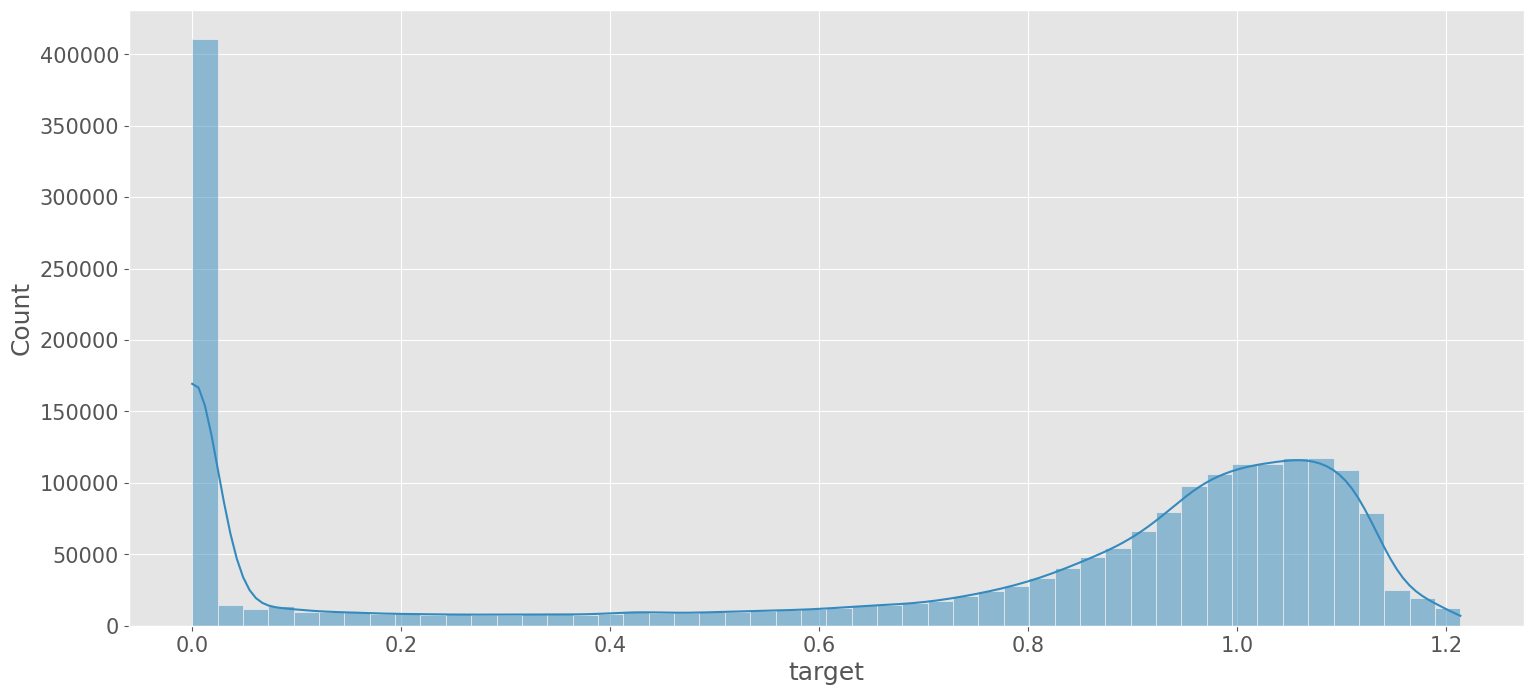

In [141]:
train["target"] = np.log1p(train["target"])
plt.figure(figsize=(18,8))
sns.histplot(train['target'], bins=50, kde=True, )
plt.show()

### 2.3 Distribution of Categorical Variables

In [91]:
df_is_bus = (train.is_business.value_counts(normalize=True)*100).to_frame()
df_county = (train.county.value_counts(normalize=True)*100).to_frame()
df_prod = (train.product_type.value_counts(normalize=True)*100).to_frame()
df_is_con = (train.is_consumption.value_counts(normalize=True)*100).to_frame()

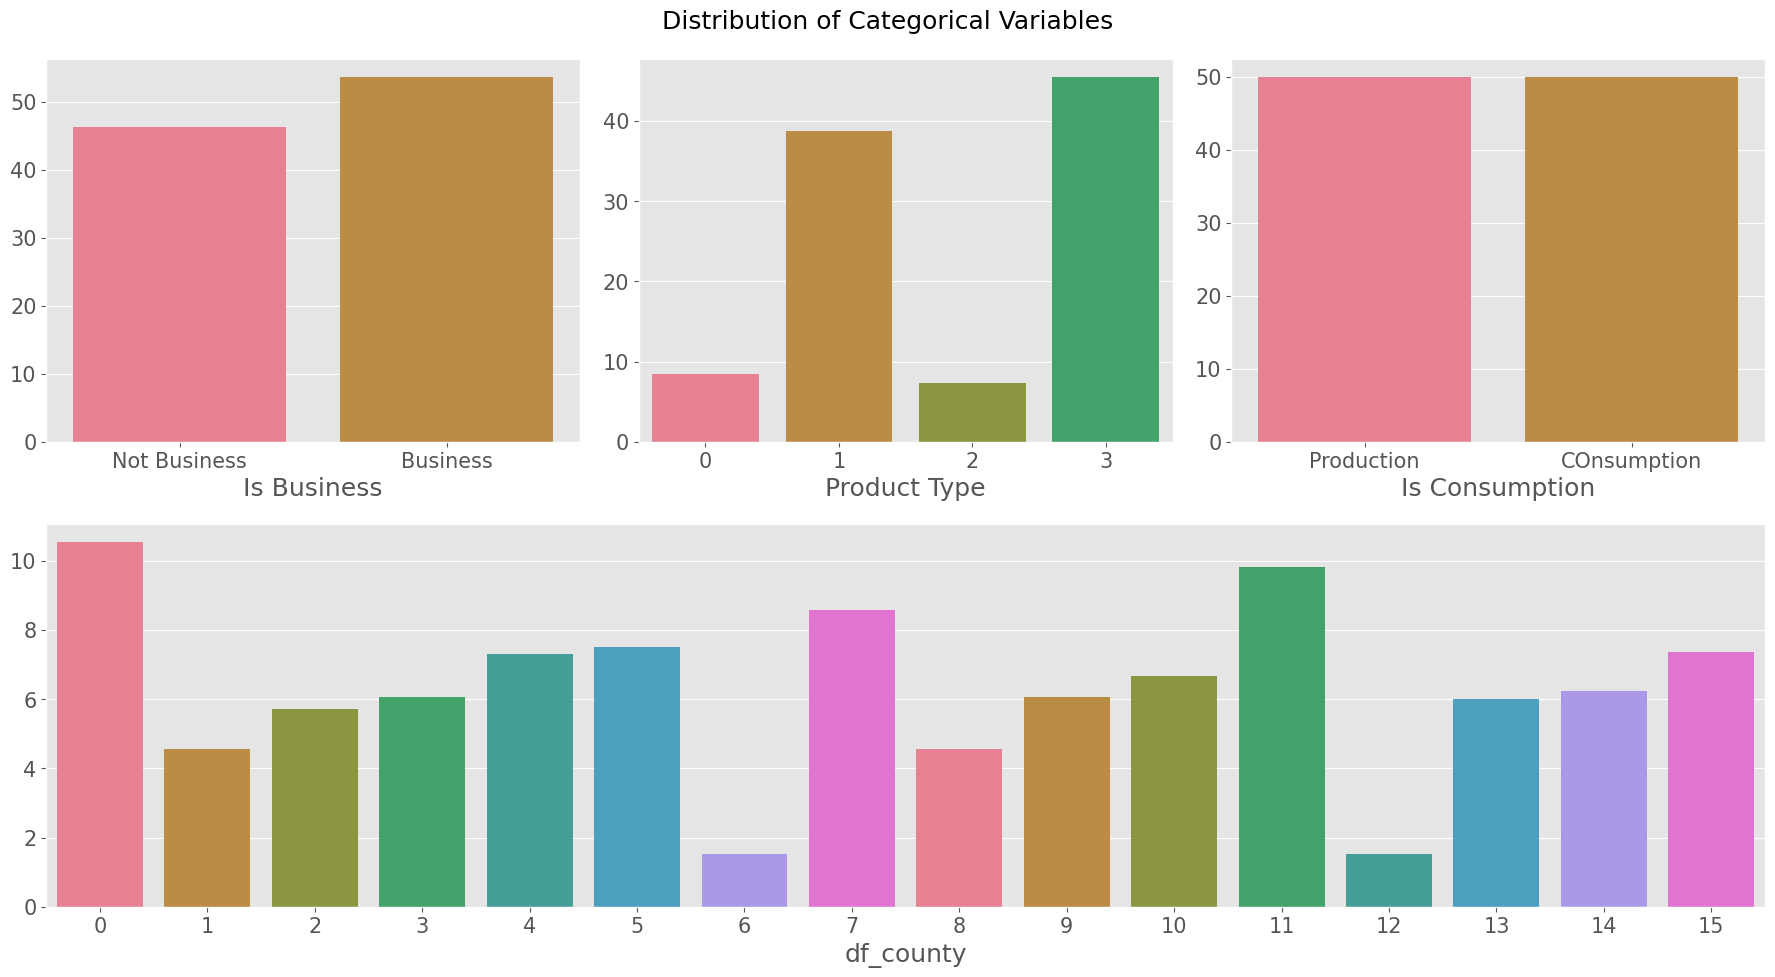

In [111]:
plot_properties = {
        "palette": COLORS,
    }

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3)

sns.barplot(
    x=df_is_bus.index.values,
    y=df_is_bus.is_business.values,
    ax=fig.add_subplot(gs[0, 0]),
    **plot_properties,
)
plt.xticks([0, 1], ["Not Business", "Business"])
plt.xlabel("Is Business")

sns.barplot(
    y=df_prod.product_type.values,
    x=df_prod.index.values,
    ax=fig.add_subplot(gs[0, 1]),
    **plot_properties,
)
plt.xlabel("Product Type")

sns.barplot(
    y=df_is_con.is_consumption.values,
    x=df_is_con.index.values,
    ax=fig.add_subplot(gs[0, 2]),
    **plot_properties,
)
plt.xticks([0, 1], ["Production", "COnsumption"])
plt.xlabel("Is Consumption")

sns.barplot(
    y=df_county.county.values,
    x=df_county.index.values,
    ax=fig.add_subplot(gs[1, :]),
    **plot_properties
)
plt.xlabel("df_county")

plt.suptitle("Distribution of Categorical Variables")
plt.tight_layout()
plt.show()

### 2.4 Distribution of target by the categorical variables

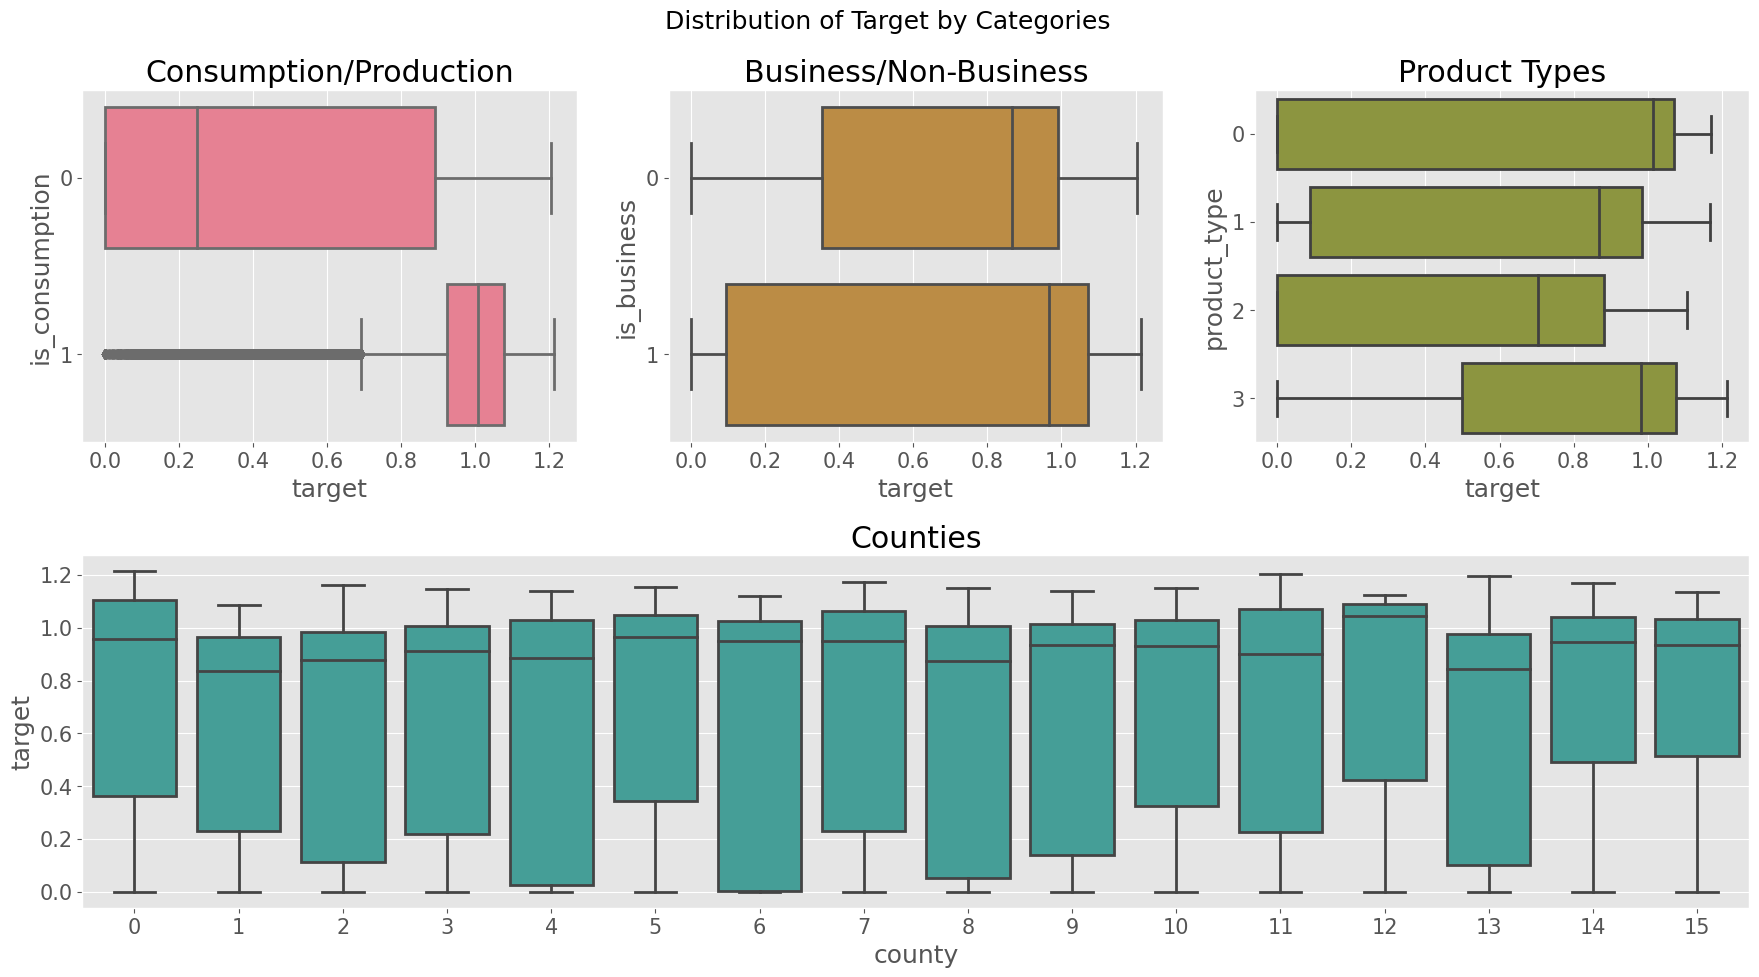

In [147]:
plot_properties = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
plot_properties2 = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "v",
    }
    
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3)

sns.boxplot(
    data=train,
    y="is_consumption",
    x="target",
    color=COLORS[0],
    ax=fig.add_subplot(gs[0, 0]),
    **plot_properties,
)
plt.title("Consumption/Production")

sns.boxplot(
    data=train,
    y="is_business",
    x="target",
    color=COLORS[1],
    ax=fig.add_subplot(gs[0, 1]),
    **plot_properties,
)
plt.title("Business/Non-Business")

sns.boxplot(
    data=train,
    y="product_type",
    x="target",
    color=COLORS[2],
    ax=fig.add_subplot(gs[0, 2]),
    **plot_properties,
)
plt.title("Product Types")

sns.boxplot(
    data=train,
    y="target",
    x="county",
    color=COLORS[4],
    ax=fig.add_subplot(gs[1, :]),
    **plot_properties2,
)
plt.title("Counties")

plt.suptitle("Distribution of Target by Categories")
plt.tight_layout()
plt.show()

### 2.5 Distribution of target over time

In [143]:
train["day"] = train.date.dt.day
train["month"] = train.date.dt.month
train["year"] = train.date.dt.year
train["day_of_week"] = train.date.dt.dayofweek
train["day_of_year"] = train.date.dt.dayofyear
train["week_of_year"] = train.date.dt.isocalendar().week.astype(int)
train["date_index"] = train.date.factorize()[0]
train["hour_of_day"] = train.datetime.dt.hour

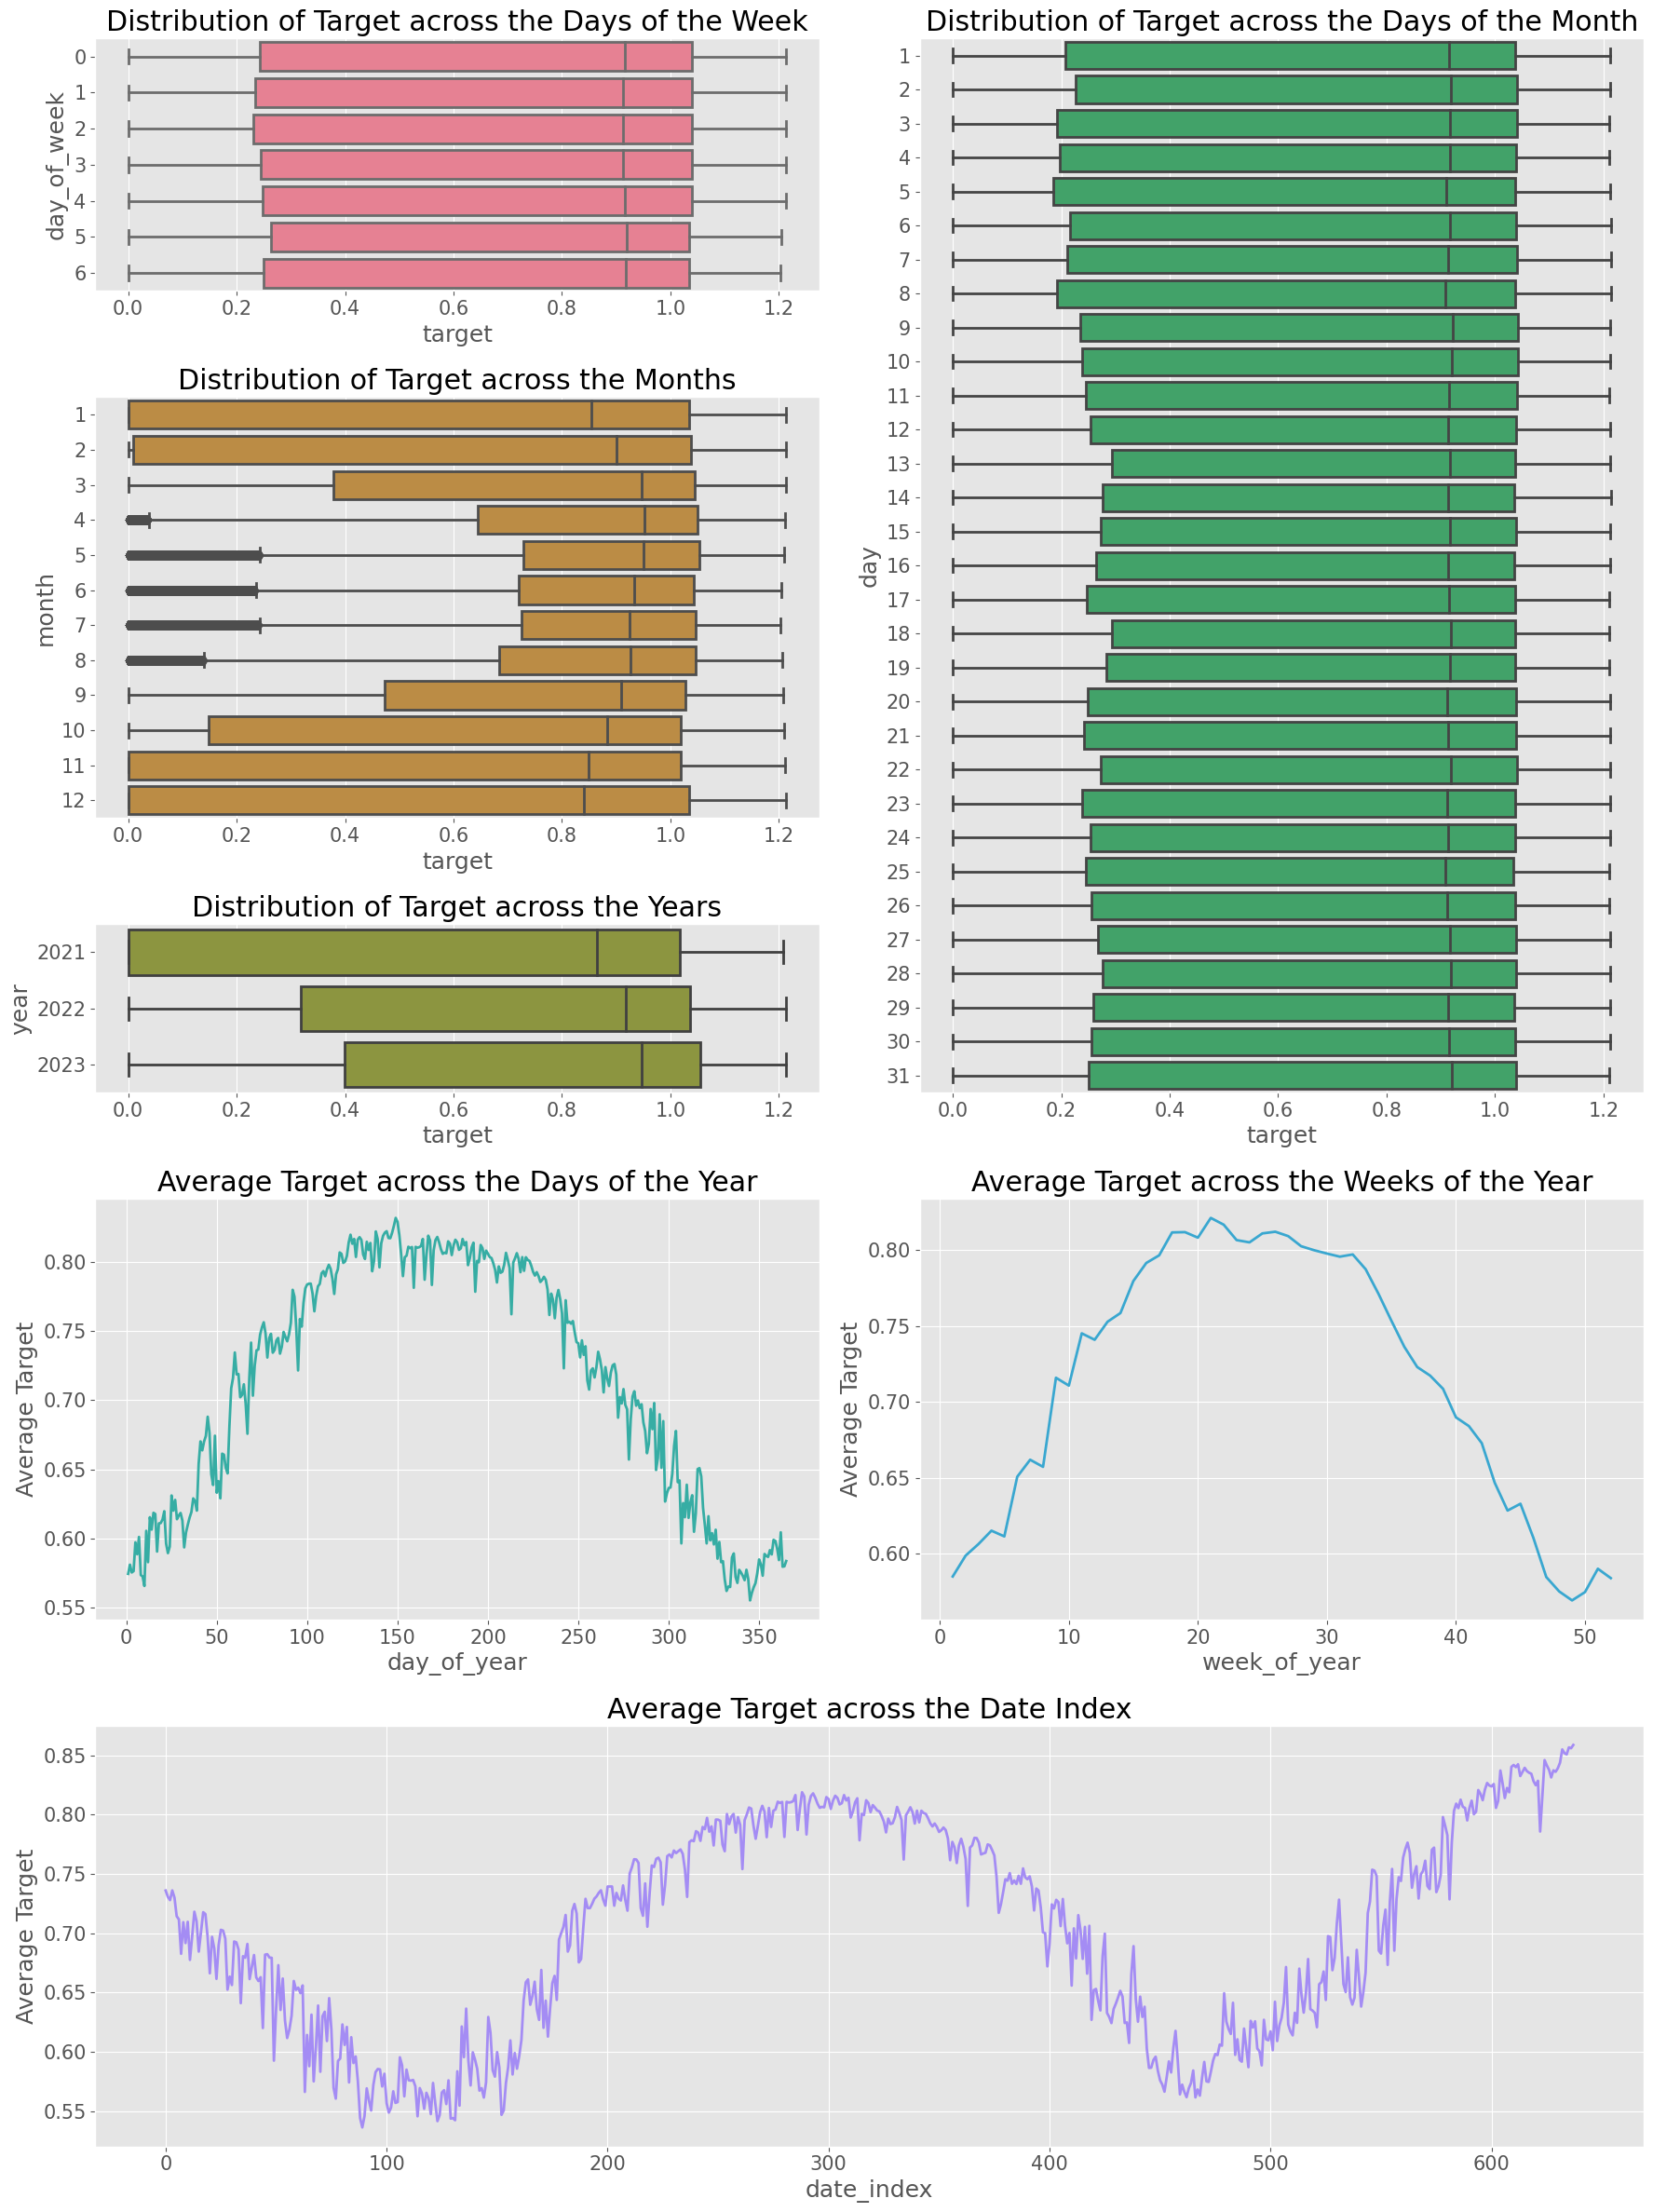

In [145]:
plot_properties = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
    
fig = plt.figure(figsize=(18, 24))
gs = fig.add_gridspec(5, 2, height_ratios=(3, 5, 2, 5, 5))

sns.boxplot(
    data=train,
    y="day_of_week",
    x="target",
    color=COLORS[0],
    ax=fig.add_subplot(gs[0, 0]),
    **plot_properties,
)
plt.title("Distribution of Target across the Days of the Week")

sns.boxplot(
    data=train,
    y="month",
    x="target",
    color=COLORS[1],
    ax=fig.add_subplot(gs[1, 0]),
    **plot_properties,
)
plt.title("Distribution of Target across the Months")

sns.boxplot(
    data=train,
    y="year",
    x="target",
    color=COLORS[2],
    ax=fig.add_subplot(gs[2, 0]),
    **plot_properties,
)
plt.title("Distribution of Target across the Years")

sns.boxplot(
    data=train,
    y="day",
    x="target",
    color=COLORS[3],
    ax=fig.add_subplot(gs[:3, 1]),
    **plot_properties,
)
plt.title("Distribution of Target across the Days of the Month")

sns.lineplot(
    data=train.groupby("day_of_year").target.mean().reset_index(),
    x="day_of_year",
    y="target",
    color=COLORS[4],
    ax=fig.add_subplot(gs[3, 0]),
    linewidth=2,
)
plt.ylabel("Average Target")
plt.title("Average Target across the Days of the Year")

sns.lineplot(
    data=train.groupby("week_of_year").target.mean().reset_index(),
    x="week_of_year",
    y="target",
    color=COLORS[5],
    ax=fig.add_subplot(gs[3, 1]),
    linewidth=2,
)
plt.ylabel("Average Target")
plt.title("Average Target across the Weeks of the Year")

sns.lineplot(
    data=train.groupby("date_index").target.mean().reset_index(),
    x="date_index",
    y="target",
    color=COLORS[6],
    ax=fig.add_subplot(gs[4, :]),
    linewidth=2,
)
plt.ylabel("Average Target")
plt.title("Average Target across the Date Index")

plt.tight_layout()
plt.show()

### 2.7 Installed capacity ocer time

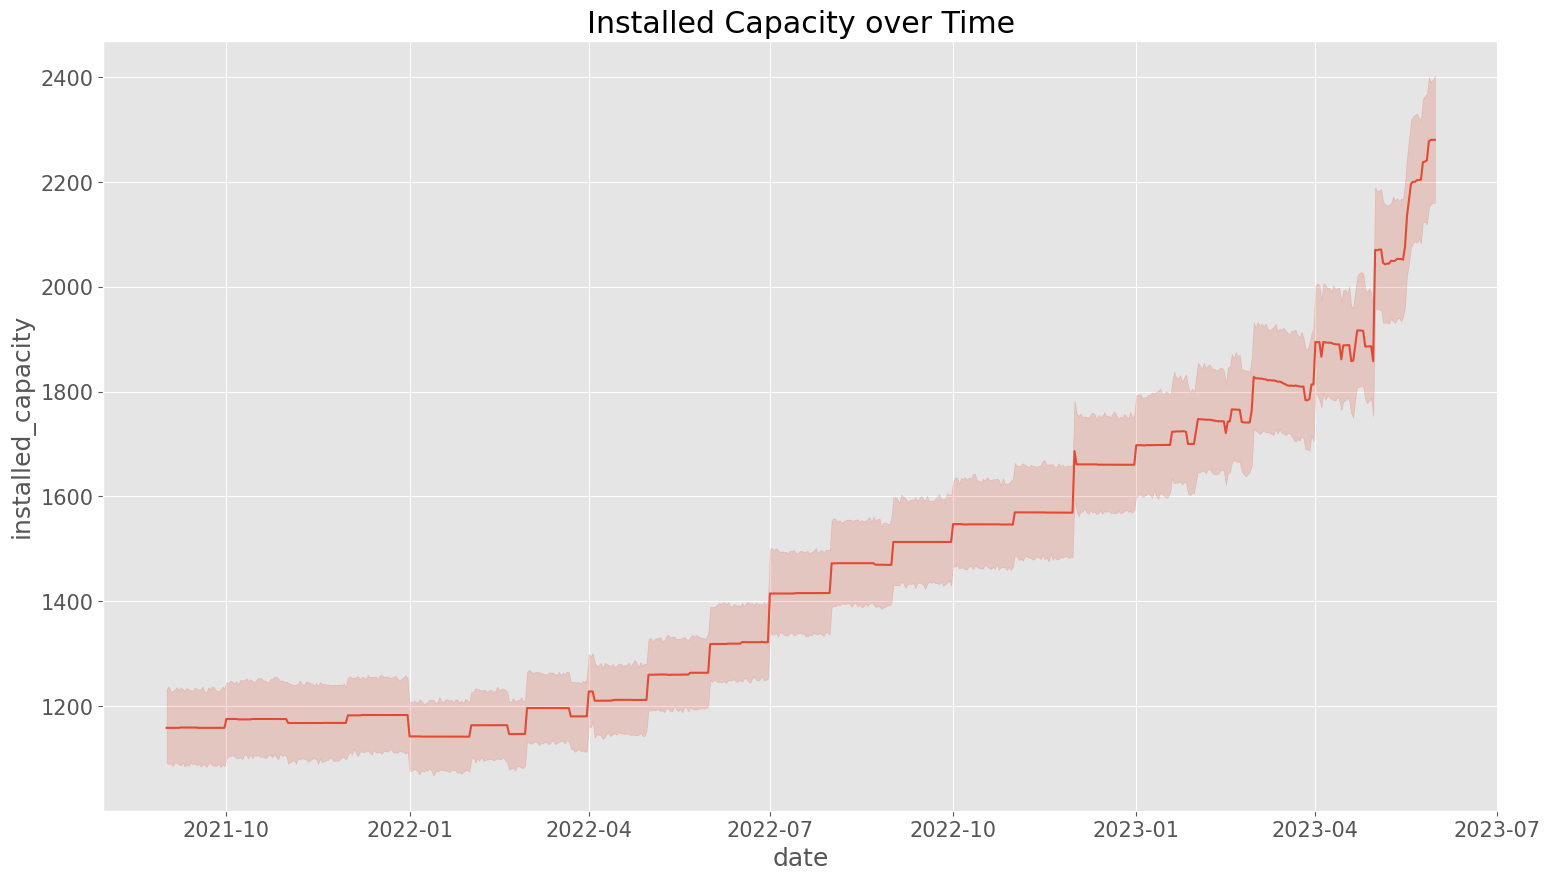

In [148]:
plt.figure(figsize=(18, 10))
sns.lineplot(x="date", y="installed_capacity", data=train)
plt.title("Installed Capacity over Time")
plt.show()

### 2.7 Installed capacity by Product/Business/County

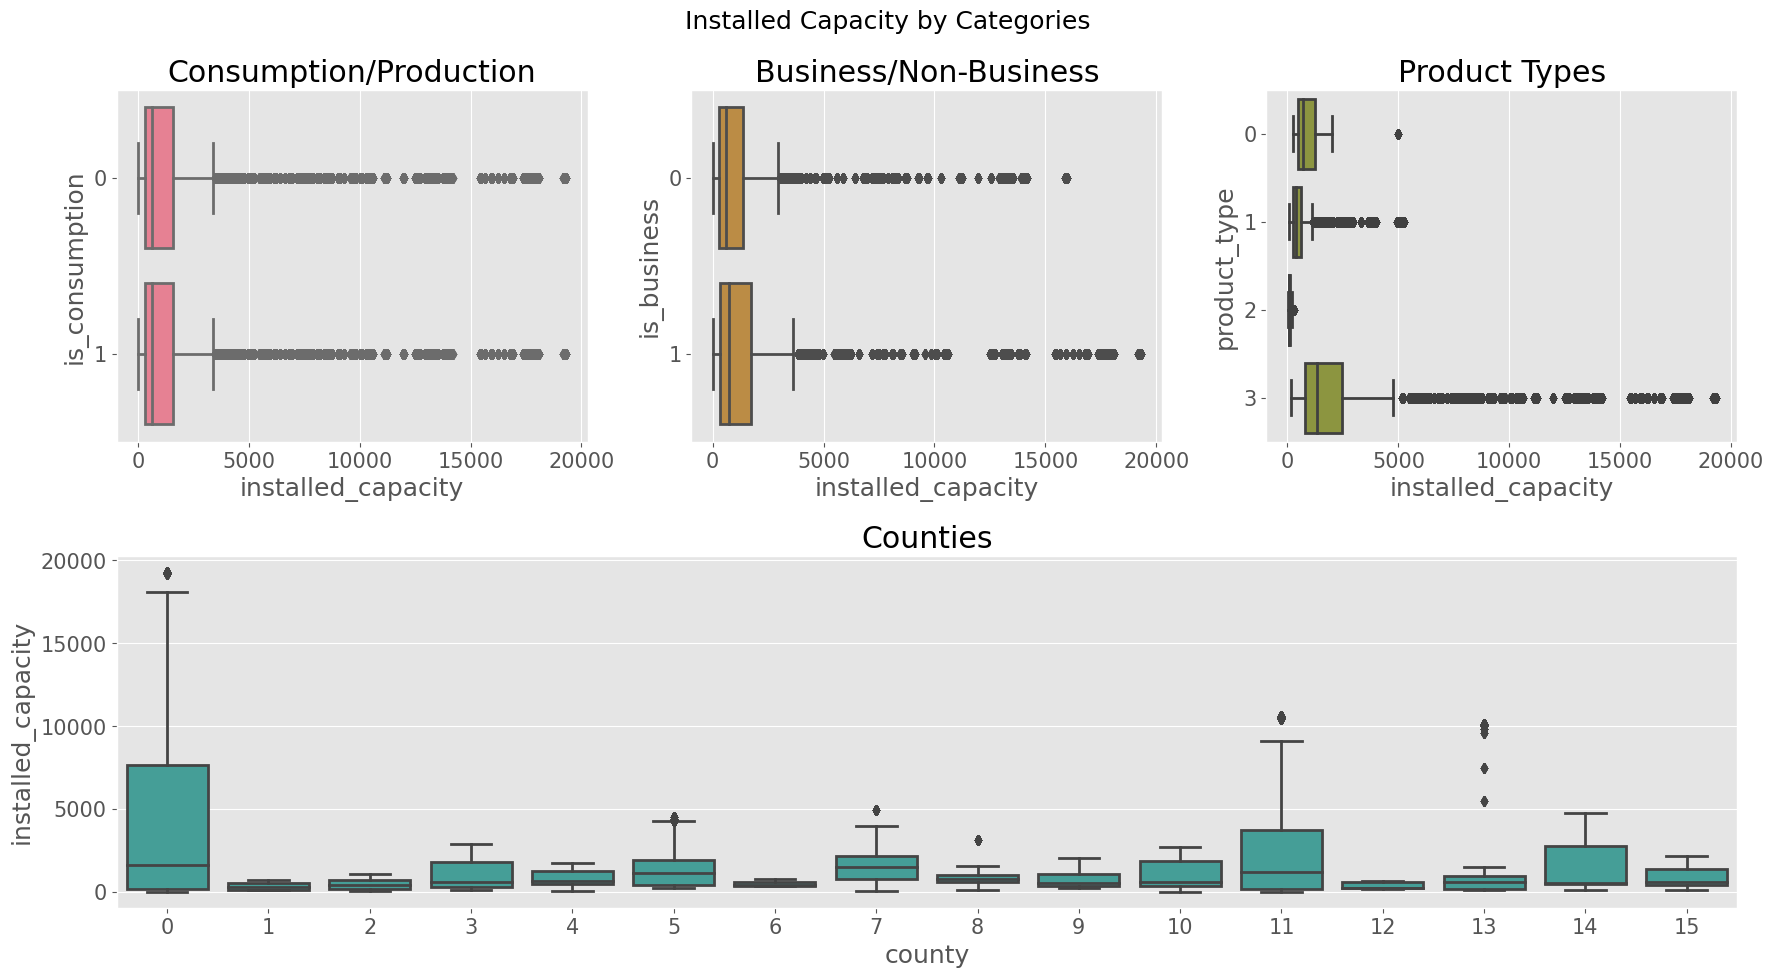

In [149]:
plot_properties = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
plot_properties2 = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "v",
    }
    
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3)

sns.boxplot(
    data=train,
    y="is_consumption",
    x="installed_capacity",
    color=COLORS[0],
    ax=fig.add_subplot(gs[0, 0]),
    **plot_properties,
)
plt.title("Consumption/Production")

sns.boxplot(
    data=train,
    y="is_business",
    x="installed_capacity",
    color=COLORS[1],
    ax=fig.add_subplot(gs[0, 1]),
    **plot_properties,
)
plt.title("Business/Non-Business")

sns.boxplot(
    data=train,
    y="product_type",
    x="installed_capacity",
    color=COLORS[2],
    ax=fig.add_subplot(gs[0, 2]),
    **plot_properties,
)
plt.title("Product Types")

sns.boxplot(
    data=train,
    y="installed_capacity",
    x="county",
    color=COLORS[4],
    ax=fig.add_subplot(gs[1, :]),
    **plot_properties2,
)
plt.title("Counties")
plt.suptitle("Installed Capacity by Categories")
plt.tight_layout()
plt.show()